# Resampling Methods (Linear Regression -- Loan Club Dataset)

In the last notebook, we further investigated our loan club dataset, and developed a linear regression model to predict the total payment for a given loan.

To better understand our regression model, resampling methods can give insights not only on the regression coefficients statistics, but also on their distributions. Thus, we can infer more the population from our finite sample. However, it should be noted that linear regression is a relatively simple model. Bootstrap is more informative with relatively more complicated models. 

In this notebook, we are discussing a powerfull resampling technique; Bootstrap. Bootstrap is based on sampling (with replacement) from our dataset, and performing our modeling technique on this subsample. This is done for multiple replications on a relatively large sample size. A larger number of replications and a sample size can better estimate the entire population from the finite sample. Since Bootstrap is computionally expensive, it is used for delivering final insights on the model, not for exploration purposes.

Let's see how Bootstrap works for our loan club dataset.

### Import neccessary libraries:
See packages description in last notebook.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from scipy import stats 
from statsmodels.graphics.regressionplots import abline_plot
from statsmodels.graphics.gofplots import ProbPlot
from statsmodels.compat import lzip
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.diagnostic import het_white

import sklearn.linear_model as lm

from IPython.display import Markdown, display

# Reset all styles to the default:
plt.rcParams.update(plt.rcParamsDefault)
# Then make graphs inline:
%matplotlib inline

# Useful function for Jupyter to display text in bold:
def displaybd(text):
    display(Markdown("**" + text + "**"))

In [2]:
# Set custom style settings:
# NB: We need to separate "matplotlib inline" call and these settings into different
# cells, otherwise the parameters are not set. This is a bug somewhere in Jupyter
plt.rcParams['figure.figsize'] = (7, 6)
plt.rcParams['font.size'] = 18
plt.rcParams['legend.fontsize'] = 'large'
plt.rcParams['figure.titlesize'] = 'large'
plt.rcParams['lines.markersize'] = 7

### Helper Functions:
These diagnostic plots help inspect the validity of linear regression models. See last notebook for more details.

In [3]:
# Diagnostic plots:
# Based on https://medium.com/@emredjan/emulating-r-regression-plots-in-python-43741952c034
def make_diagnostic_plots(reg_res, ydata):
    yhat = reg_res.fittedvalues
    ehat = reg_res.resid
    pnum = len(reg_res.params) # number of model parameters
    # Studentized residuals
    ehatStudentized = reg_res.get_influence().resid_studentized_internal
    # Asolute squared studentized residuals
    ehatStudentizedAbsSqrt = np.sqrt(np.abs(ehatStudentized))
    # absolute residuals
    ehatAbs = np.abs(ehat)
    # leverage:
    xleverage = reg_res.get_influence().hat_matrix_diag
    # Cook's distance:
    modelCooks = reg_res.get_influence().cooks_distance[0]

    fig = plt.figure(figsize=[13, 11.5])
    plt.subplots_adjust(wspace=0.3, hspace=0.5)

    #-- RESIDUAL PLOT:

    ax = fig.add_subplot(2, 2, 1)
    sns.residplot(yhat, ydata, lowess=True, ax=ax,
                  scatter_kws={'alpha': 0.5}, 
                  line_kws={'color': 'red', 'lw': 3, 'ls': '--', 'alpha': 1.0})
    ax.set_title('Residuals vs Fitted')
    ax.set_xlabel('Fitted values')
    ax.set_ylabel('Residuals')

    # Annotations for the largest residuals:
    yPointsTop3 = ehatAbs.sort_values(ascending=False)[:3]
    for i in yPointsTop3.index:
        ax.annotate(i, xy=(1.01*yhat[i], 1.01*ehat[i]), fontsize=14);

    #-- QQ PLOT:
    # This one shows how well the distribution of residuals fit the normal distribution.
    # This plots the standardized (z-score) residuals against the theoretical normal quantiles.
    # Anything quite off the diagonal lines may be a concern for further investigation.

    ax = fig.add_subplot(2, 2, 2)
    QQ = ProbPlot(data=ehatStudentized, fit=True)
    QQ.qqplot(line='45', alpha=0.5, color='#4C72B0', lw=2, ls="--", ax=ax)
    ax.set_title('Normal Q-Q')
    ax.set_xlabel('Theoretical Quantiles')
    ax.set_ylabel('Studentized Residuals');

    # Annotations for the largest residuals:
    yPointsTop3 = np.flip(np.argsort(np.abs(ehatStudentized)), 0)[:3]
    for r, i in enumerate(yPointsTop3):
        xy = (1.01 * np.flip(QQ.theoretical_quantiles, 0)[r], 1.01 * ehatStudentized[i])
        ax.annotate(i, xy=xy, fontsize=14);

    #-- SCALE-LOCATION PLOT:

    ax = fig.add_subplot(2, 2, 3)
    plt.scatter(yhat, ehatStudentizedAbsSqrt, alpha=0.5)
    sns.regplot(yhat, ehatStudentizedAbsSqrt, scatter=False, ci=False, 
                lowess=True,
                line_kws={'color': 'red', 'lw': 3, 'ls':'--', 'alpha': 0.9},
                ax=ax)

    ax.set_title('Scale-Location')
    ax.set_xlabel('Fitted values')
    ax.set_ylabel('$\sqrt{|Studentized\; Residuals|}$');

    # Annotations for the largest residuals:
    yPointsTop3 = np.flip(np.argsort(ehatStudentizedAbsSqrt), 0)[:3]
    for i in yPointsTop3:
        ax.annotate(i, xy=(1.01*yhat[i], 1.01*ehatStudentizedAbsSqrt[i]), fontsize=14);

    #-- LEVERAGE PLOT:
    # This plot shows if any outliers have influence over the regression fit.
    # Anything outside the group and outside “Cook’s Distance” lines, may have
    # an influential effect on model fit.

    ax = fig.add_subplot(2, 2, 4)
    plt.scatter(xleverage, ehatStudentized, alpha=0.5)
    sns.regplot(xleverage, ehatStudentized, scatter=False, 
                ci=False, lowess=True,
                line_kws={'color': 'red', 'lw': 3, 'ls':'--', 'alpha': 0.8},
                ax = ax);
    ax.set_xlim(np.min(xleverage) - 0.001, 1.05*np.max(xleverage))
    ax.set_ylim(1.05*np.min(ehatStudentized), 2*np.max(ehatStudentized))
    ax.set_title('Residuals vs Leverage')
    ax.set_xlabel('Leverage')
    ax.set_ylabel('Studentized Residuals')

    # Annotations for the points with the largest Cook's distance:
    yPointsTop3 = np.flip(np.argsort(modelCooks), 0)[:3]
    for i in yPointsTop3:
        ax.annotate(i, xy=(1.01*xleverage[i], 1.01*ehatStudentized[i]), fontsize=14)

    # Shenanigans for Cook's distance contours
    def graph(formula, x_range, label=None):
        x = x_range
        y = formula(x)
        plt.plot(x, y, label=label, lw=2, ls=':', color='green')

    

    graph(lambda x: np.sqrt((0.5 * pnum * (1 - x)) / x), 
          np.linspace(0.001, 0.200, 50), 
          'Cook\'s distance') # 0.5 line
    graph(lambda x: np.sqrt((1 * pnum * (1 - x)) / x), 
          np.linspace(0.001, 0.200, 50)) # 1 line
    plt.legend(loc='upper right', fontsize=14);

In [28]:
# We can do the plot of the original data along with the fitted line:
def residual_scatter(res):
    minval = np.min([np.min(res.fittedvalues), np.min(res.model.endog)])
    maxval = np.max([np.max(res.fittedvalues), np.max(res.model.endog)])
    plt.scatter(x=res.fittedvalues, y=res.model.endog, alpha=0.1)
    # Draw the 45-degree line:
    plt.plot([minval, maxval], [minval, maxval], linestyle="--", color="red", linewidth=3)
    plt.title('The Residual Scatter')
    plt.xlabel('Fitted Values')
    plt.ylabel('Data')
    plt.tight_layout()

# Linear Regression Model

In the last notebooks, we derived a linear regression model to predict the total payment of a given loan given different features of the loan. The model with the highest $R^2(0.99)$  was a **Log-Linear** regression model using the features; loan amount, interest rate, and term.

We will reconstruct the basic model again, and show some of its characteristics.

In [25]:
# Load sampled and cleaned loan club dataset
datetime_cols = ['issue_d','earliest_cr_line','last_pymnt_d','last_credit_pull_d']
loan_club = pd.read_csv('Loan_sampled_cleaned.csv',parse_dates = datetime_cols)

important_cols = ['loan_amnt','loan_status','term','int_rate','total_pymnt']
loan_club_fully_paid = loan_club[loan_club['loan_status']=='Fully Paid'].reset_index(drop=True)
loan_club_fully_paid_log = loan_club_fully_paid[important_cols].copy()
loan_club_fully_paid_log.drop(['loan_status'],axis = 1,inplace=True)

loan_club_fully_paid_log['loan_amnt'] = np.log(loan_club_fully_paid['loan_amnt'])
loan_club_fully_paid_log['int_rate'] = np.log(loan_club_fully_paid['int_rate'])
loan_club_fully_paid_log['total_pymnt'] = np.log(loan_club_fully_paid['total_pymnt'])

display(loan_club_fully_paid_log.head())

,loan_amnt,term,int_rate,total_pymnt
0,8.853665,36 months,2.662355,9.060512
1,10.126631,60 months,2.441477,10.278362
2,8.517193,36 months,1.671473,8.597574
3,10.463103,36 months,2.660959,10.660770
4,8.699515,36 months,2.614472,8.902074


In [45]:
display(loan_club_fully_paid_log.describe(include=[np.number, np.object]))

,loan_amnt,term,int_rate,total_pymnt
count,33887.000000,33887,33887.000000,33887.000000
unique,NaN,2,NaN,NaN
top,NaN,36 months,NaN,NaN
freq,NaN,26664,NaN,NaN
mean,9.372695,NaN,2.486370,9.511778
std,0.693627,NaN,0.362809,0.708803
min,6.907755,NaN,1.669592,6.909434
25%,8.987197,NaN,2.215937,9.071666
50%,9.392662,NaN,2.513656,9.567240
75%,9.903488,NaN,2.746630,10.037244


**Our predictors include two numberic features (loan_amnt, int_rate) and one categorical feature (term). The data was cleaned from earliear investiagations.**

Let's visualize the predictor features interactions with the response feature.

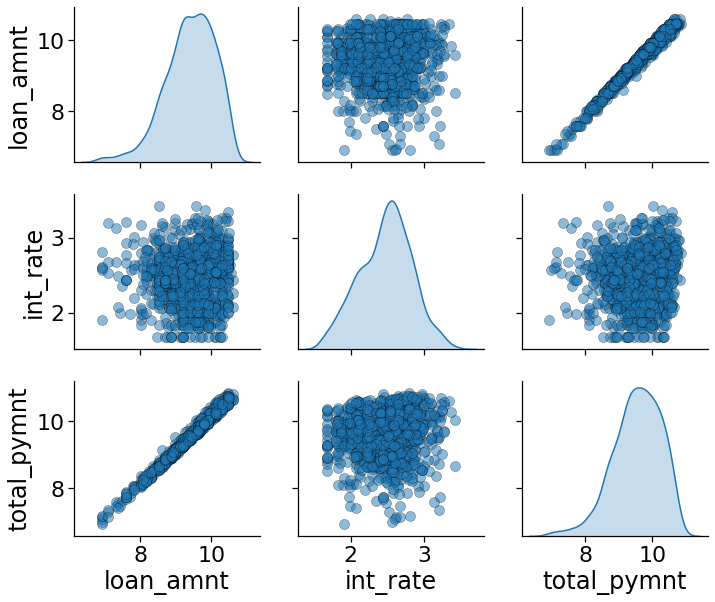

In [27]:
loan_club_vis = loan_club_fully_paid_log.sample(1000)
cols = list(loan_club_fully_paid_log.select_dtypes(include=[np.number]).columns)
# Use plotting context to tempoprary change plotting settings
# (the earlier specified font is too large)
pairplot_rc = {"lines.markersize": 10}
with sns.plotting_context("notebook", font_scale=2.0, rc=pairplot_rc):
    pp = sns.pairplot(loan_club_vis[cols],
                      height=3, aspect=1.2,
                      # Change marker styles:
                      plot_kws=dict(edgecolor="k", linewidth=0.5, alpha=0.5),
                      # "diag" adjusts/tunes the diagonal plots:
                      diag_kws=dict(shade=True),
                      diag_kind="kde")
    # Set custom space between graphs:
    pp.fig.subplots_adjust(wspace=0.2, hspace=0.2)

**The relation between the total_pymnt and loan_amnt is a strongly-linear relation.**   
**The interaction between total_pymnt and int_rate is relatively random.**  
**The total_pymnt and loan_amnt have nearly the same distribution.**

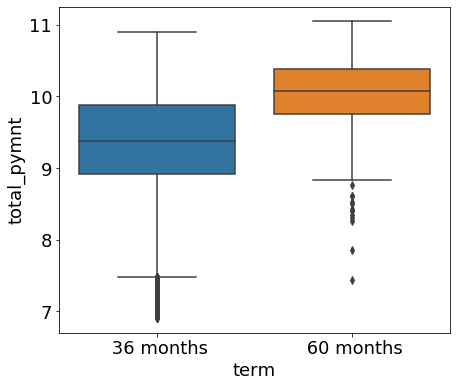

In [46]:
sns.boxplot(x='term',y='total_pymnt',data=loan_club_fully_paid_log)

**As for the categorical feature (term), loans with longer temr (60 months) have a higher total_pymnt.** 

Let's visualize the interaction of all features using a scatterplot. 

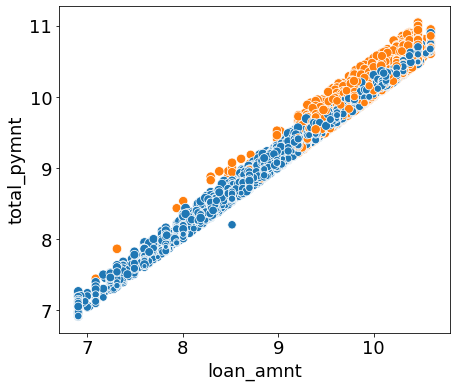

In [61]:
g = sns.scatterplot(x='loan_amnt',y='total_pymnt',hue = 'term',size = 'int_rate',legend=False, data=loan_club_fully_paid_log)

**We can see that a linear regression with these features can give a relatively good estimate of the loan total_pymnt.**

## Fit A Log-Linear Model

In [67]:
yColName = 'total_pymnt'
xColsNames = list(loan_club_fully_paid_log.columns)
xColsNames.remove('total_pymnt')
olsFormula = yColName + '~' + "+".join(xColsNames)

model = sm.OLS.from_formula(olsFormula, data=loan_club_fully_paid_log)
res = model.fit(cov_type='HC0')

res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            total_pymnt   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                 1.082e+06
Date:                Wed, 27 May 2020   Prob (F-statistic):               0.00
Time:                        16:30:16   Log-Likelihood:                 40904.
No. Observations:               33887   AIC:                        -8.180e+04
Df Residuals:                   33883   BIC:                        -8.177e+04
Df Model:                           3                                         
Covariance Type:                  HC0                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -0.1747      0.006    -27.364      0.000      -0.187      -0.162
term[T. 60 months]     0.0323      0.001     22.669      0.000       0.029       0.035
loan_amnt              1.0041      0.001   1738.643      0.000       1.003       1.005
int_rate               0.1079      0.001     86.920      0.000       0.106       0.110
==============================================================================
Omnibus:                      973.077   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2406.919
Skew:                          -0.091   Prob(JB):                         0.00
Kurtosis:                       4.293   Cond. No.                         166.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC0)
"""

**The fittness of the model is quite high with $R^2 = 0.99$**  
**All the coefficients are significant with nearly zero p-value.**  
**Due to the log transformation, we loss interpretiblity of the coefficients.**

Let's visualize the good of fittness of a residual scatter.

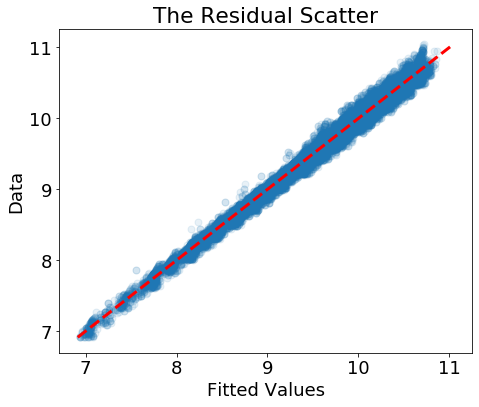

In [29]:
residual_scatter(res)

**The fitted values lay almost around the $45^o$ line. This means a very high goodness of fit.**

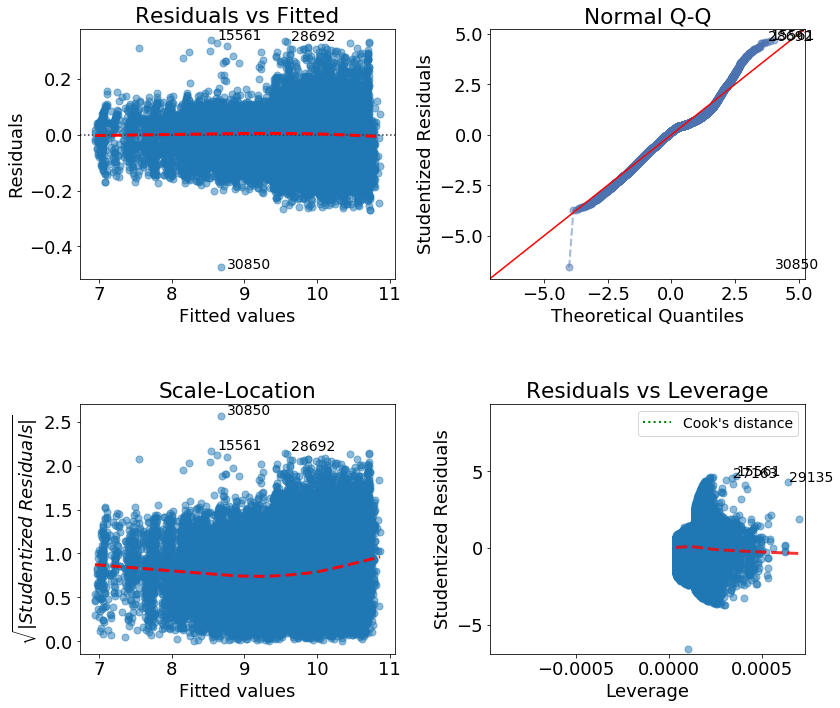

In [9]:
make_diagnostic_plots(res, loan_club_fully_paid_log['total_pymnt'])

**The diagnostic plot doesn't show a clear problem with current model. There exists some hetroskedacticity especially at large values of y; however, our model should be robust to hetroskedacticity. The data is also almost normally-distributed. We can see few but not very significant outliers and leverage points which we can overlook for the mean time.**

# Nonparametric/Paired Bootstrap

From our OLS model, we can get some summary statistics about the coefficients; however, we know a little about their distributions. Bootsrap can help use gain more insights by estimating the coefficients distributions. We can thus get better approximations of the standard errors and confidence intervals; especially in cases of asymmetry.

Here's a summary for OLS.

In [66]:
# Base OLS estimates to use later in bootstrap
base_theta_hat = res.params.to_numpy()
# Base t-statistics:
base_t = base_theta_hat / res.HC0_se.to_numpy()
base_std = res.HC0_se.to_numpy()

linear_reg_df = pd.DataFrame(data={'OLS Coefficients' : base_theta_hat,
                                    'OLS stardard error' : base_std,
                                 'OLS t-statstic' : base_t},
                             index=res.model.exog_names)

displaybd("OLS summary:")
linear_reg_df

**OLS summary:**

,OLS Coefficients,OLS stardard error,OLS t-statstic
Intercept,-0.174729,0.006385,-27.363996
term[T. 60 months],0.032286,0.001424,22.669425
loan_amnt,1.004115,0.000578,1738.643465
int_rate,0.107935,0.001242,86.920338


## Bootstrap on OLS

We create multiple replications (samples with replacement) of the same size of the original dataset. Within each sample, we fit an OLS model of the data. We can then get a distribution of the coeffiecients and their t-statistic. We use a relatively large number of replications to converge to the exact properties of the populations.

In [19]:
theta_star_sampling = []
sample_size = loan_club_fully_paid_log.shape[0]
replicats = 5000
for _ in range(replicats):
    model = sm.OLS.from_formula(olsFormula, data=loan_club_fully_paid_log.sample(sample_size,replace = True))
    res = model.fit()
    # t-statistic:
    # IMPORTANT: Which standard error to use here? White-standard error or the
    # usual standard error? I think White standard error, but I am not sure...
    t = (res.params - base_theta_hat) / res.HC0_se
    theta_star_sampling.append(np.append(res.params, t))
theta_star_sampling = np.array(theta_star_sampling)

**Let's visualize the sampled coefficients and their statistics.**

In [70]:
theta_star = theta_star_sampling[:, 0:4]
t_star = theta_star_sampling[:, 4:]

bootstrap_sample = pd.DataFrame(data={'Bootstrap Sample Coefficients' : theta_star[0],
                                 'Bootstrap Sample t-statstic' : t_star[0]},
                             index=res.model.exog_names)
displaybd("Bootstrap sample:")
bootstrap_sample

**Bootstrap sample:**

,Bootstrap Sample Coefficients,Bootstrap Sample t-statstic
Intercept,-0.175887,-0.181733
term[T. 60 months],0.032072,-0.151171
loan_amnt,1.004553,0.755391
int_rate,0.106755,-0.957721


**We can now use our bootstrapped sampled to estimate the coefficients distributions.**

## a) Coefficients Distributions

To visualize the distribution, we use seaborn distplot which shows a both a histogram of the distribution and a density plot. According to the law of large numbers, we expect our distributions to approach normal distribution. Thus, we include an additional plot of a normal distribution of the same mean and standard deviation of our coefficient distribution.

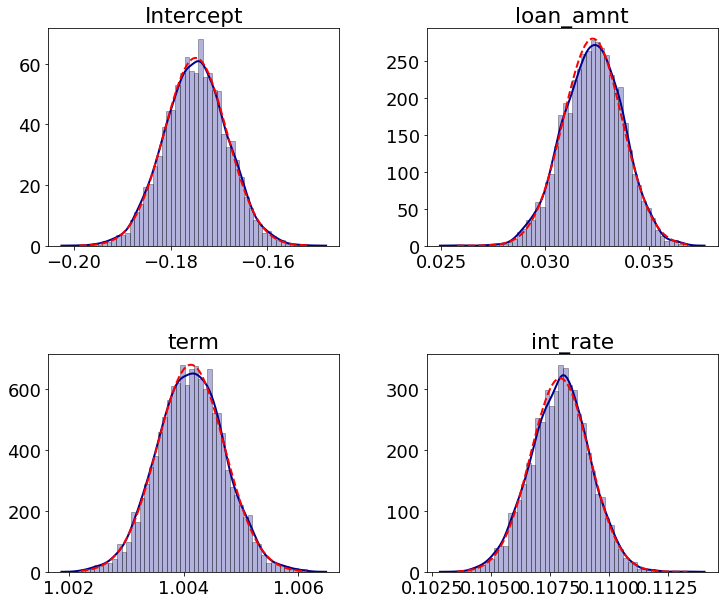

In [20]:
xcolsNmb = 2
xColsNamesIntercept = ['Intercept'] + xColsNames
xrowsNmb = -(-len(xColsNamesIntercept) // xcolsNmb) # Ceil division

fig = plt.figure(figsize=[12, 5 * xrowsNmb])
plt.subplots_adjust(wspace=0.3, hspace=0.5)

for i in range(len(xColsNamesIntercept)):
    ax = fig.add_subplot(xrowsNmb, xcolsNmb, i + 1)

    coefName = xColsNamesIntercept[i]

    theta_hat = theta_star[:, i]
    theta_mean, theta_std = stats.norm.fit(theta_hat)
    theta_min = np.min(theta_hat)
    theta_max = np.max(theta_hat)

    x = np.linspace(theta_min, theta_max, 100)
    nprmalpdf = stats.norm.pdf(x, theta_mean, theta_std)

    sns.distplot(theta_hat, hist=True, kde=True, 
                      bins=50, color='darkblue',
                      hist_kws={'edgecolor':'black', 'alpha':0.3},
                      kde_kws={'linewidth': 2})

    ax.plot(x, nprmalpdf, 'r--', linewidth=2)
    ax.set_title(coefName)

**From these plots of the coefficients distributions, we can notice some bias in all of them. We can also find a slight asymmetry in all of them. These findings are important when estimating condidence intervals since we need to account for this bias.**

## b) Standard Errors

One important usage of bootstrap is to estimate the standard errors of the coefficients; especially in cases when it is not possible to estimate with some other analyitcal approach. Bootstrap can also useful to validate the standard errors obtained through other techniques. 

In [31]:
# NB: We need to have ddof=1 to have an unbiased estimate of std
theta_hat_std = theta_star.std(axis=0, ddof=1)
coef_df = pd.DataFrame(data={'OLS Robust' : res.HC0_se,
                             'Paired Bootstrap' : theta_hat_std},
                             index=res.model.exog_names)

displaybd("Standard Errors:")
coef_df

**Standard Errors:**

,OLS Robust,Paired Bootstrap
Intercept,0.006344,0.006446
term[T. 60 months],0.001441,0.001424
loan_amnt,0.000577,0.000587
int_rate,0.001244,0.001252


**The obtained standard errors through OLS and Bootstrap are almost identical. It is expected since we have used a relatively large number of replications. In theory, Bootstrap standard will approach robust standard errors as numbers of replications approach infinity. Thus, for a linear regression, robust standard errors can provide a better estimate of the population standard error compared to bootstrap.**

## c) Confidence Intervals

Reporting confidence interval can give better insights on the coefficients compared to a single-value estimate. To obtain the confidence interval, there exists several methods. Some of them has better properties than others in practice. Let's compare some of them.

In [78]:
#-- ROBUST STANDARD ERRORS
theory_cil = base_theta_hat - 1.96 * base_std
theory_cih = base_theta_hat + 1.96 * base_std

#-- BIAS-CORRECTED PERCENTILE METHOD:
ql = 0.025
qh = 0.975
median_bias = (theta_star <= base_theta_hat).mean(axis=0)
# Percentile point function of the Normal distribution (i.e., CDF inverse):
normal_median_bias = stats.norm.ppf(median_bias) 
normal_critical_val_l = stats.norm.ppf(ql)
normal_critical_val_h = stats.norm.ppf(qh)
ql_corrected = stats.norm.cdf(normal_critical_val_l + 2*normal_median_bias)
qh_corrected = stats.norm.cdf(normal_critical_val_h + 2*normal_median_bias)

boot_v3_cil = [np.quantile(theta_star[:, idx], q, axis=0, interpolation='lower')
     for idx, q in enumerate(ql_corrected)]
boot_v3_cih = [np.quantile(theta_star[:, idx], q, axis=0, interpolation='lower')
     for idx, q in enumerate(qh_corrected)]

#-- t-PERCENTILE CONFIDENCE INTERVAL:

t_star_l = np.quantile(t_star, qh, axis=0, interpolation='lower')
t_star_h = np.quantile(t_star, ql, axis=0, interpolation='lower')
boot_v4_cil = base_theta_hat - t_star_l * base_std
boot_v4_cih = base_theta_hat - t_star_h * base_std

ci_df = pd.DataFrame(data={'L OLS' : theory_cil,
                            'U OLS' : theory_cih,
                            'L boots_percent_unbiased' : boot_v3_cil,
                            'U boots_percent_unbiased' : boot_v3_cih,
                            'L boots_Asympt_refined' : boot_v4_cil,
                            'U boots_Asympt_refined' : boot_v4_cih},
                            index=res.model.exog_names)

displaybd("95% confidence intervals:")
ci_df

**95% confidence intervals:**

,L OLS,U OLS,L boots_percent_unbiased,U boots_percent_unbiased,L boots_Asympt_refined,U boots_Asympt_refined
Intercept,-0.187245,-0.162214,-0.187418,-0.162276,-0.187185,-0.162004
term[T. 60 months],0.029494,0.035077,0.029326,0.034981,0.029565,0.035147
loan_amnt,1.002983,1.005247,1.002938,1.005226,1.002967,1.005245
int_rate,0.105501,0.110369,0.105345,0.110305,0.105523,0.110456


Due to the simplicity of the model used as well as the relation between the response and the predictors, we can see that the upper and lower confidence intervals  are almost identical for all methods. Having close CI can give us more confidence in our estimates of the CI.

In the above table, CI was calculated using three main methods:

**ROBUST STANDARD ERRORS:**  
In this case, we use the OLS coefficients and the corresponding standard errors (1.96 is 97.5 percentile of z-distribution).

**BOOTSTRAP PERCENTILE UNBIASED:**  
As we could see from the coefficients distributions, there exists some bias and asymmetry. Using OLS to estimate CI can thus result in biased CI.
Bootstrap can be used to estimate the CI through knowledge of coefficient distributions, if it is difficult to calculate the standard errors using other methods. Bootstrap percentile can reduce the bias of our CI estimate.

**BOOTSTRAP t-PERCENTILE:**  
It can also give unbiased estimates of the CI in cases when standard errors can be estimated from other methods (i.e. OLS robust standard errors). This Asymptotic-refined appoach can coverge faster to true population CI compared to theoritical CI (i.e. OLS). 
